In [8]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
from lib.fno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDataset

In [9]:
modes = 16
width = 64
fno = FNO1d(modes, width)  # model

# load model weights
fno.load_state_dict(torch.load("models/fno_model.pth"))

/tmp/ipykernel_139832/332940895.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno.load_state_dict(torch.load("models/fno_model.pth"))


<All keys matched successfully>

In [10]:
BATCH_SIZE = 10

In [11]:
test_data = PDEDataset("data/test_sol_OOD.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input_batch in progress_bar:
        input = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        prediction = fno(input).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()

test_relative_l2 /= len(test_data_loader)
print(f"Test relative L2 error: {test_relative_l2}")

100%|██████████| 13/13 [00:00<00:00, 281.20it/s]

Test relative L2 error: 0.11746470228983806


In [13]:
# pick N random samples and draw prediction and target
N = 10
samples = test_data[np.random.randint(0, len(test_data), N)]

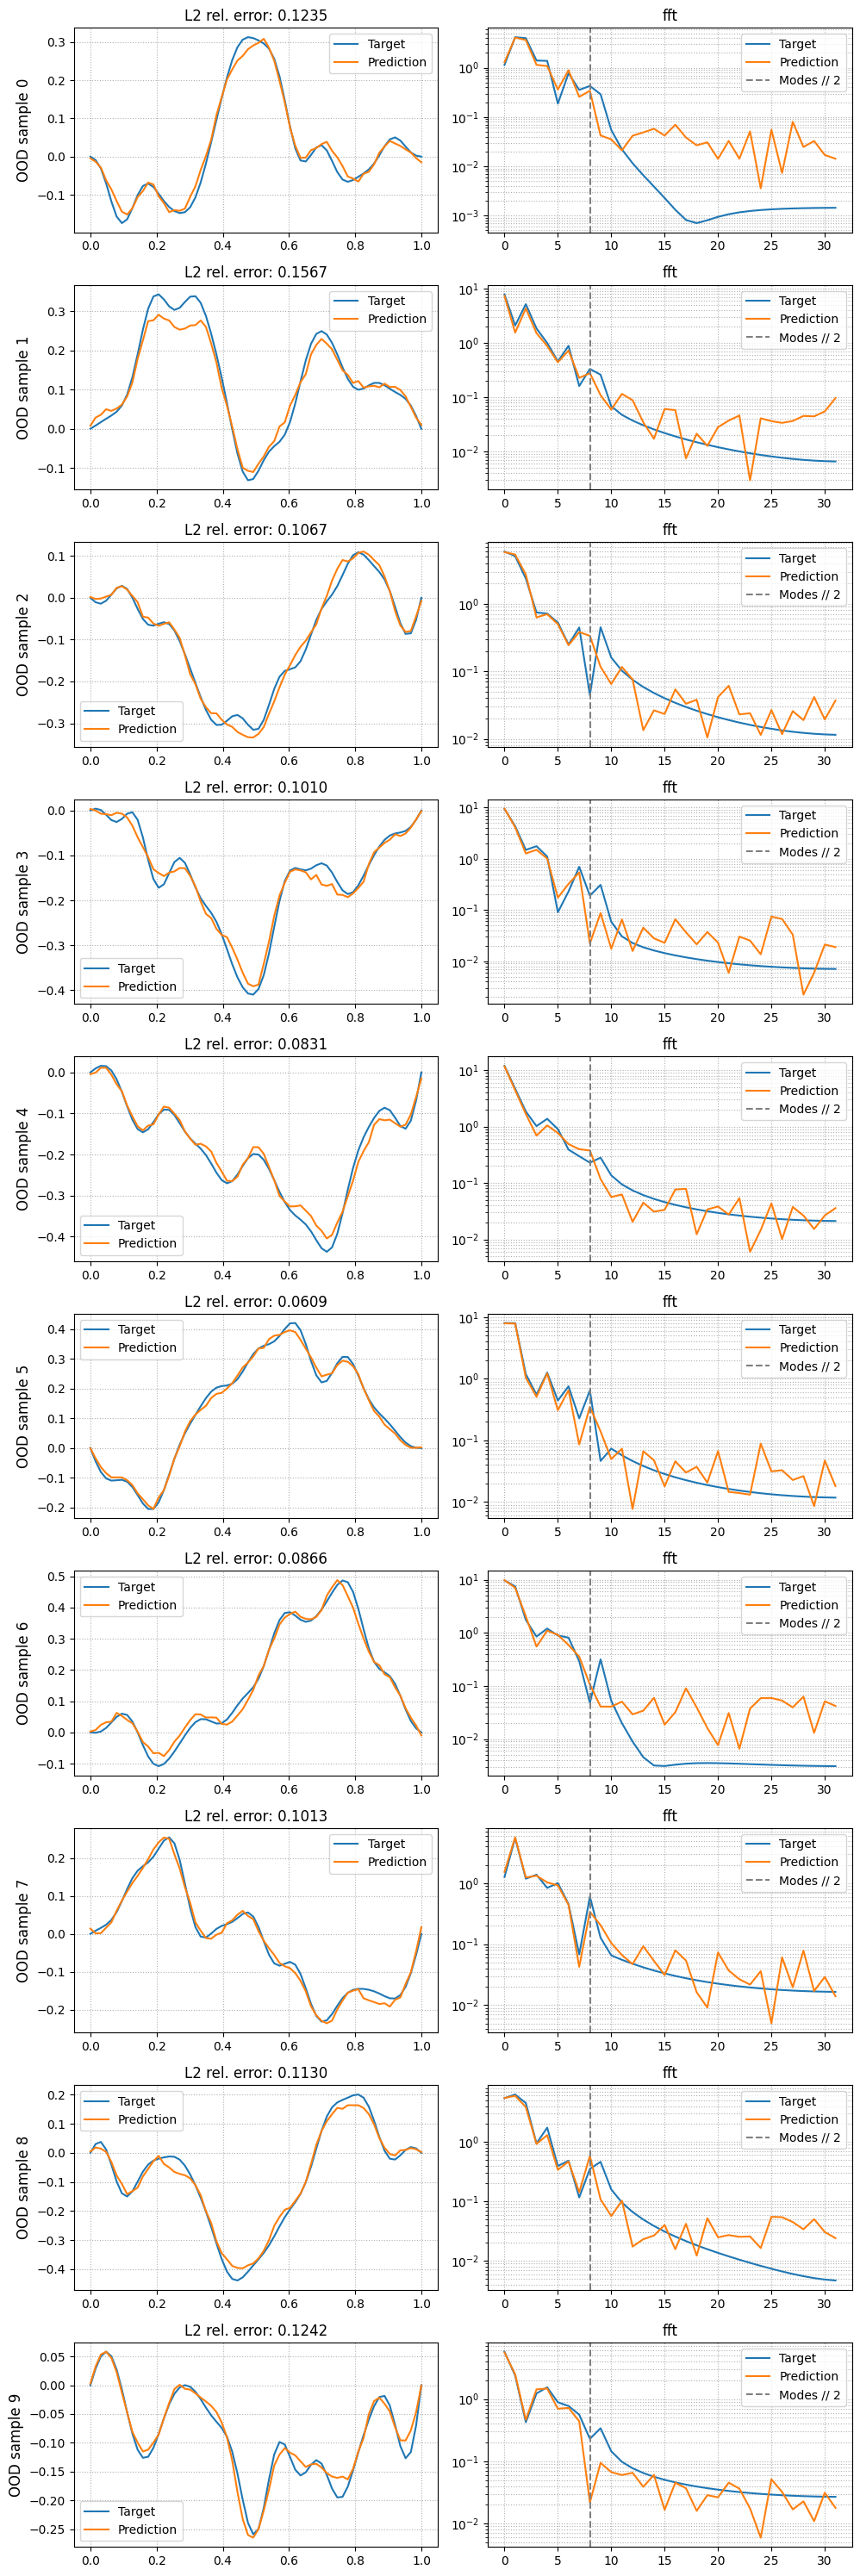

In [14]:
fig, axs = plt.subplots(N, 2, figsize=(10, 30))

fno.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input = sample[0, :].unsqueeze(0)
        target = sample[-1, :, 0].unsqueeze(0)

        prediction = fno(input).squeeze(-1)

        re_l2_error = relative_l2_error(prediction, target)

        ax = ax_rows[0]

        ax.set_ylabel(f"OOD sample {i}", fontsize=12)

        ax.plot(
            sample[0, :, 1].numpy(),
            target.squeeze(0).numpy(),
            label="Target",
        )
        ax.plot(
            sample[0, :, 1].numpy(),
            prediction.squeeze(0).numpy(),
            label="Prediction",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")

        ax = ax_rows[1]
        ax.set_yscale("log")

        # plot freqiencies spectrum of target and prediction
        target_fft = np.fft.fft(target.squeeze(0).numpy())
        prediction_fft = np.fft.fft(prediction.squeeze(0).numpy())

        ax.plot(
            np.abs(target_fft)[: len(target_fft) // 2],
            label="Target",
        )

        ax.plot(
            np.abs(prediction_fft)[: len(prediction_fft) // 2],
            label="Prediction",
        )

        ax.axvline(modes // 2, color="gray", ls="--", label="Modes // 2")

        ax.set_title("fft")
        ax.legend()
        ax.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()